A 3-layer flat MLP of 64 neurons per layer, scored the lowest MSE in our test of 4 architecture types.

Let's look at the data of this MLP, and also learn how to save the weights and biases, and how to use it for s one step-ahead forecast.

#### Full Specification
- Layers 3
- Layer In: Input
  - dimension: 9 neurons
  - activation: input neurons do not use activation funtcions
- Layer 1: Hidden
  - dimension: 64 neurons
  - activation: ReLU
- Layer 2: Hidden
  - dimension: 64 neurons
  - activation: ReLU
- Layer 3: Hidden
  - dimension: 64 neurons
  - activation: ReLU
- Layer Out: Output
  - dimension: 1 neuron
  - activation: None. This makes sense since we are trying to replicate a value
- Epochs: 1000
- Loss Function: MSE
- Optimization Method: Adam
- MSE on final epoch: 0.00013208114798526547

### We'd like to build the specific model above

In [9]:
# Build it
# code from run_normd_MLP_static.py
# regular imports
import pandas as pd
import os
import numpy as np
import datetime

# other imports
import inspect
import sys
import time

# the file
snpnormfile = "Reuters Data Copy/SandP500/snp_normalized_lagged.csv"
snp_a_data = pd.read_csv(snpnormfile,parse_dates=['Local_Datetime'],
                         index_col=0)

# just to keep from changing to many variable names below
snp_data_chrono = snp_a_data

# define MLP dataset
# we need to leave a validation set, which we can use for test later
y = snp_data_chrono['Close']
y_train = y.iloc[:1347-135]
y_validation = y.iloc[1347-135:]
X_train = snp_data_chrono.iloc[:1347-135,2:]
X_validation = snp_data_chrono.iloc[1347-135:,2:]

# for NN first imports
# for tensorflow with keras
import tensorflow
# due to a problem on Windows, force the aliasing
sys.modules['keras'] = tensorflow.keras

# for NN second imports
from keras.models import Sequential
from keras.layers import Dense


/Users/revit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### at this point inthe code, we introduce a lattic of different epochs, nodes and layers.
I suppose, we can just fill this list with a single item

In [15]:
# here are our bases for configurations
cross_config = []
# epics = [250,500,1000]
# lyrz = [1,2,3,4]
# nodz = [32,64,128]

#for epic in epics:
#    for layer in lyrz:
#        for node in nodz:
#            cross_config.append([epic,layer,node])

flat_config_1000_3_64 = [1000,3,64]
cross_config.append(flat_config_1000_3_64)
cross_config

[[1000, 3, 64]]

In [16]:
# make a model based on the config

def config_model(lyr,nod):
    model_info = {"layers":lyr,
                  "layer":{}
                 }
    
    new_model = Sequential()

    # define model
    new_model.add(Dense(nod, activation="relu", input_dim=9))
    model_info["layer"][1] = nod
    
    # define the hidden layers
    if (lyr>1):
        for this_layer in range(1,lyr):
                nod_now = nod
                new_model.add(Dense(nod_now,activation="relu"))
                model_info["layer"][this_layer+1] = nod_now
                
    # the loop does this for every extra hidden layer
    # finally, we add the output layer
    
    new_model.add(Dense(1))

    return new_model, model_info

# notice it returns abbreviated config info
    # e.g. {'layer': {1: 64, 2: 64, 3: 64, 4: 64}, 'layers': 4}

# we still have to compilte afterward, then fit

def train_a_config(trial):
    noepoch = trial[0]
    nolayer = trial[1]
    nonodes = trial[2]
    curr_model, curr_info = config_model(nolayer,nonodes)
    
    curr_model.compile(optimizer="adam", loss="mse")
    
    trn_model = curr_model.fit(X_train, y_train,
                               validation_data=(X_validation,y_validation),
                               epochs=noepoch, verbose=0)

    ret_dict = {"epochs":trn_model.epoch[-1]+1,
                "config":curr_info,
                "result":trn_model.history}
    return ret_dict

# where to save results
#file_out = "normd_MLP_results.txt"
#tempf = open(sav_res,'w')
#tempf.close()
#time.sleep(3)


In [17]:
# where to save results
#file_out = "normd_MLP_results.txt"
#tempf = open(sav_res,'w')
#tempf.close()
#time.sleep(3)

# cross_config is our test_list
def train_all_mlps(test_list,sav_res):
    # info for screen
    listlen = len(test_list)
    for test in test_list:
        # info for screen
        test_order = 1+test_list.index(test)
        
        test_result = train_a_config(test)
        fsav = open(sav_res,'a')
        fsav.write(str(test_result))
        fsav.write('\n')
        fsav.close()
        # to print to screen
        epout = test_result["epochs"]
        szout = test_result["config"]["layers"]
        to_print = "{} of {}: Trained {} epochs, on {} layers. Saved."
        print(to_print.format(test_order,listlen,epout,szout))


#### We don't need to save to disk, but it's fine if we do

In [13]:
nbksaveflenm = "mlp_winner_01nbk_output.txt"

if a name is not supplied, it will save to a file called "-f"

In [18]:
if __name__ == "__main__":
    print('\n')
    print(len(cross_config)," : configurations to train\n")
    train_all_mlps(cross_config,nbksaveflenm)



1  : configurations to train

1 of 1: Trained 1000 epochs, on 3 layers. Saved.


It take just under 1 minute to train this (3 layer, 64, 64, 64 neuron) MLP network via Jupyter Notebook

### We modify this to return a trained model to us.
We need to figure out where the weights/bias info is

In [19]:
def train_a_config_return_a_model(trial):
    noepoch = trial[0]
    nolayer = trial[1]
    nonodes = trial[2]
    curr_model, curr_info = config_model(nolayer,nonodes)
    
    curr_model.compile(optimizer="adam", loss="mse")
    
    trn_model = curr_model.fit(X_train, y_train,
                               validation_data=(X_validation,y_validation),
                               epochs=noepoch, verbose=0)

    ret_dict = {"epochs":trn_model.epoch[-1]+1,
                "config":curr_info,
                "result":trn_model.history}
    return ret_dict, trn_model

In [21]:
MLP_dict, MLP_trained = train_a_config_return_a_model(flat_config_1000_3_64)

In [27]:
MLP_trained.model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_6", "layers": [{"class_name": "Dense", "config": {"name": "dense_17", "trainable": true, "batch_input_shape": [null, 9], "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_18", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint":

In [28]:
MLP_trained.model.weights

[<tf.Variable 'dense_17/kernel:0' shape=(9, 64) dtype=float32>,
 <tf.Variable 'dense_17/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_18/kernel:0' shape=(64, 64) dtype=float32>,
 <tf.Variable 'dense_18/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_19/kernel:0' shape=(64, 64) dtype=float32>,
 <tf.Variable 'dense_19/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_20/kernel:0' shape=(64, 1) dtype=float32>,
 <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32>]

### we learn how to save the weights to a file

In [29]:
MLP_trained.model.save_weights("MLP_weight_save_test01.h5")

### we now save the model config

In [33]:
MLP_model_json = MLP_trained.model.to_json()
with open("MLP_model_save_test01.json", "w") as json_file:
    json_file.write(MLP_model_json)

\# load json and create model  
json_file = open('model.json', 'r')  
loaded_model_json = json_file.read()  
json_file.close()  
loaded_model = model_from_json(loaded_model_json)  

\# load weights into new model  
loaded_model.load_weights("model.h5")  
print("Loaded model from disk")  
 
\# evaluate loaded model on test data  
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  
score = loaded_model.evaluate(X, Y, verbose=0)  
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))  


### Allows us to bild a model from a config

In [31]:
from keras.models import model_from_json

In [35]:
stored_model_info = open("MLP_model_save_test01.json",'r')
loaded_model_info = stored_model_info.read()
stored_model_info.close()

loaded_model = model_from_json(loaded_model_info)

W1008 14:53:04.180463 140735722779584 deprecation.py:506] From /Users/revit/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1008 14:53:04.189088 140735722779584 deprecation.py:506] From /Users/revit/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [36]:
# load weights into new model
loaded_model.load_weights("MLP_weight_save_test01.h5")
print("Loaded model from disk")

Loaded model from disk


In [37]:
# evaluate loaded model on test data
loaded_model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_validation, y_validation, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 0.74%


In [54]:
MLP_trained.model.evaluate(X_validation, y_validation, verbose=1)

135/135 [==============================] - 0s 142us/sample - loss: 6.5319e-05


6.531900483726834e-05

In [58]:
preds = MLP_trained.model.predict(X_validation)

In [64]:
preds[:5]

array([[0.9039668 ],
       [0.91235477],
       [0.9169746 ],
       [0.9196155 ],
       [0.9189695 ]], dtype=float32)

In [65]:
copypreds = preds.copy()

In [69]:
copypreds.reshape((1,135))

array([[0.9039668 , 0.91235477, 0.9169746 , 0.9196155 , 0.9189695 ,
        0.92071927, 0.9162564 , 0.9238107 , 0.94228745, 0.94579464,
        0.9379847 , 0.9423332 , 0.9463122 , 0.9419098 , 0.9437326 ,
        0.9468029 , 0.9552797 , 0.94737697, 0.9558586 , 0.9546777 ,
        0.94659555, 0.94203335, 0.9484967 , 0.9563378 , 0.96056426,
        0.96254873, 0.96369034, 0.9612968 , 0.9643599 , 0.9676897 ,
        0.97093755, 0.9755031 , 0.9773047 , 0.97612345, 0.97210854,
        0.970463  , 0.9698169 , 0.9748485 , 0.9751327 , 0.9771063 ,
        0.9729108 , 0.97526336, 0.9703295 , 0.9614063 , 0.9676835 ,
        0.9611113 , 0.9645174 , 0.9618742 , 0.96264195, 0.9506443 ,
        0.9492547 , 0.9497209 , 0.9496663 , 0.94753337, 0.9402343 ,
        0.93363154, 0.9247391 , 0.9362854 , 0.9250429 , 0.9294245 ,
        0.9312873 , 0.9424114 , 0.94220686, 0.9476509 , 0.9609617 ,
        0.95477754, 0.9522016 , 0.9517921 , 0.95027936, 0.94052505,
        0.9361894 , 0.92407113, 0.93111634, 0.93

In [70]:
y_validation

6943    0.915639
6883    0.920710
6823    0.921596
6763    0.921744
6703    0.923311
          ...   
231     0.981907
171     0.981390
111     0.973895
51      0.948337
13      0.930200
Name: Close, Length: 135, dtype: float64

In [51]:
MLP_trained.model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


# Up to this point, we retrained the winning MLP model. Then, we modified one of the functions fomr the .py file to return the trained model. With the trained model, we could call its function to save both its architecture and weights to disc. We then loaded those items into a brand new model, and scored the model. I used our validation data.

In [50]:
len(y)

1347

# Our model searching didn't use a "metrics" item, but that's okay, since we can just use MSE (metrics can be same or different from loss). However, we didn't hold out a trainining set, only a valdation set of 135 rows, which is around 10% of the data.

## We may want to use the best MLP on only 80% of the data, and have 10% validation and 10% for testing.

- can we graph this?

In [87]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

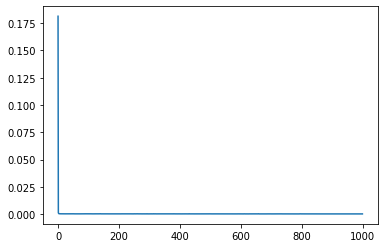

In [78]:
plt.plot(MLP_trained.history['loss'])

In [81]:
ordered_losses = tuple(MLP_trained.history['loss'])

In [82]:
ordered_losses

(0.18135435258425625,
 0.0013565721492461318,
 0.0004471846599333148,
 0.00034129011117017187,
 0.00030599051253507435,
 0.0002653700848115399,
 0.00026570984211184774,
 0.00024751651831483775,
 0.0002423782809675908,
 0.0002342679618708728,
 0.00029225400969825634,
 0.00023795965823257288,
 0.00023737767681121372,
 0.00024243680099040736,
 0.0002256633871655278,
 0.00022246180079752892,
 0.0002218695237760804,
 0.0002174283216074232,
 0.0002257817685327465,
 0.00021150315666637343,
 0.00020897517734969482,
 0.00023505243943603064,
 0.0002054891745669755,
 0.0002147327197397515,
 0.0002071934188771824,
 0.00021043832257479158,
 0.00021420430084467611,
 0.00021366050773109662,
 0.00024970686824864744,
 0.0002285476628746284,
 0.00021353517866481354,
 0.00021165934559026973,
 0.000249349850119651,
 0.00020565304330015315,
 0.00021104426893540858,
 0.0002151714157038015,
 0.0002079583122298927,
 0.00027487179820184527,
 0.000253590912210045,
 0.0002471262724722794,
 0.00023508853997621014

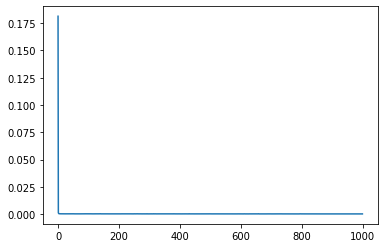

In [83]:
plt.plot(ordered_losses)

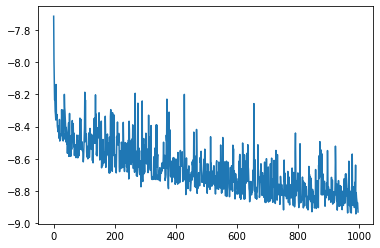

In [95]:
plt.plot(np.log(ordered_losses[2:]))

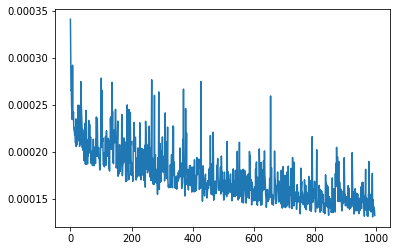

In [98]:
plt.plot(ordered_losses[3:])

## Notes on SGD
https://stats.stackexchange.com/questions/406183/does-keras-sgd-optimizer-implement-batch-mini-batch-or-stochastic-gradient-des

Gradent descent would mean batch size =1, and would update the gradien after every samepl
Stochastic Gradient Descent



The pseudocode sketch below summarizes the gradient descent algorithm:

`model = initialization(...)
n_epochs = ...
train_data = ...
for i in n_epochs:
	train_data = shuffle(train_data)
	X, y = split(train_data)
	predictions = predict(X, model)
	error = calculate_error(y, predictions)
    model = update_model(model, error)`
    
Okay so GD doesn't update until we calculate the error from ALL the prediction in one epoch

SGD updates the wieghts after every record in a single epoch

batch SGD... more the 1 record but less than all records, for updates

- Gradient Descent: updating the network after using the loss from just __ALL__ observations
  - this uses overall loss, like sum of all losses


- Stochastic Gradient Descent: updating the network after using the loss from __1__ record
  - records are randomized also, to randomize how/when weights will be updated
  - > `Stochastic gradient descent, often abbreviated SGD, is a variation of the gradient descent algorithm that calculates the error and updates the model for each example in the training dataset.`


- Batch Gradient Descent: updating the network after using the loss from ??? records
  - normally, the batch size is ???
  - > `Batch gradient descent is a variation of the gradient descent algorithm that calculates the error for each example in the training dataset, but only updates the model after all training examples have been evaluated.
  One cycle through the entire training dataset is called a training epoch. Therefore, it is often said that batch gradient descent performs model updates at the end of each training epoch.`
  
#### What is Mini-Batch Gradient Descent?
- Mini-batch gradient descent is a variation of the gradient descent algorithm that splits the training dataset into small batches that are used to calculate model error and update model coefficients.

- Implementations may choose to sum the gradient over the mini-batch which further reduces the variance of the gradient.

- Mini-batch gradient descent seeks to find a balance between the robustness of stochastic gradient descent and the efficiency of batch gradient descent. It is the most common implementation of gradient descent used in the field of deep learning.


> Basically, in SGD, we are using the cost gradient of 1 example at each iteration, instead of using the sum of the cost gradient of ALL examples.
> https://towardsdatascience.com/difference-between-batch-gradient-descent-and-stochastic-gradient-descent-1187f1291aa1

> c) Mini-batch gradient descent uses __n__ data points (instead of __1__ sample in SGD) at each iteration.



### Batch = ALL
### Mini-Batch = Some
### Stochastic = 1 (w shuffle)

### Use this to implement mini-batch gradient descent, with a batch size of 40.
Keras default is 32

https://stats.stackexchange.com/questions/221886/how-to-set-mini-batch-size-in-sgd-in-keras

If you change this setting to be the length if the input data, then that would be batch, and updating would only happen at the end of 1 epoch.

Why __40__? Well, since we know that a trading day is 8 hours, and thay each record is abour a particular trading day, then we can consider 40 records to to represent $8*5=40$ $\rightarrow$ 5 business days. Therfore, 40 records would be 1 week of data. An MLP has no memory. So updating per week of data, can be a way of adding smoothing to the estimation, in hope that predictions will be better. It's like a fake form of considering a seasonal component, like a moving average.

<font color=blue size=3> Made the decision not to change Keras' default mini-batch size of 32.  
By sheer luck, we are using 9 lags in our records. So this would mean than record 32 had the close prices from 32,33,34,35,36,37,38,39 and 40 hours ago. Therefore, this technically takes 40 lags into account.
<br><br>
Moreover, an MLP can't learn long-term dependencies anyway. So turning off data randomization or changing the mini-batch size wouldn't really do much.
</font>

<font color=purple size=3>However, when we build the LSTM, we will definitely turn off the per epoch data shuffling.</font>